# 3ML with Fermi GBM TTE Data
### Purpose
Fermi GBM data is in a format that does not lend itself to being used with standard software such as XSPEC. However, the **FermiGBMLikeTTE** in **3ML** plugin allows the user to work directly with the TTE data in its native format

**FermiGBMLikeTTE** provides the following functionality
* Reading GBM TTE data
* Proper MLE polynomial background fitting
* Pure counts and light curve plotting

It creates a standard **3ML** Model and therefore can be used like any other plugin *without* using specical tools to create PHA files.

#### Let's check it out!

Import **3ML** as always to make sure you have the plugin

In [1]:
%matplotlib inline

from threeML import *



get_available_plugins()


WARNING CppInterfaceNotAvailable: The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)




Did you try to import pygsl in the build directory?

Well, that does not work out of the box. If you want to do that, please
use
      python setup.py build_ext -i
to add the necessary extension module in the local pygsl/ directory!

Please read the README first! Any further questions or missing information
please post to pygsl-discuss@lists.sourceforge.net!




WARNING GSLNotAvailable: The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.


WARNING XSpecNotAvailable: XSpec is not available.


WARNING UserWarning: ROOT minimizer not available



Configuration read from /Users/jburgess/.threeML/threeML_config.yml



WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/plugins/FermiGBM_TTE_Like.py. Do you have the relative instrument software installed and configured?


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/plugins/FermiLATLike.py. Do you have the relative instrument software installed and configured?


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/plugins/HAWCLike.py. Do you have the relative instrument software installed and configured?


WARNING CannotImportPlugin: Could not import plugin /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/thre

Available plugins:

FermiGBMLike for Fermi GBM (all detectors)
FermiGBMLikeTTE for Fermi GBM TTE (all detectors)
SwiftXRTLike for Swift XRT
OGIPLike for All OGIP-compliant instruments
VERITASLike for VERITAS


We will look at GRB080916C as a test case


**FermiGBM_TTE_Like** takes as arguments:
* a name
* the TTE file name
* background intervals separated by commas
* an inital source interval to fit
* the correct RSP file
* (optional) a polynomial order for background fitting *(0-4)*

**FermiGBM_TTE_Like** will attempt to find the best background polynomial order via a LRT.
The background is fit with an Poisson likehood via method developed by Giacomo V. 

In [2]:
# os.path.join is a way to generate system-independent
# paths (good for unix, windows, Mac...)

data_dir = os.path.join('gbm','bn080916009')

src_selection = "0.-10."


nai3 = FermiGBMLikeTTE('NAI3',
                         os.path.join(data_dir, "glg_tte_n3_bn080916009_v01.fit.gz"),
                         "-10-0, 50-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir, "glg_cspec_n3_bn080916009_v07.rsp"))

bgo0 = FermiGBMLikeTTE('BGO0',
                         os.path.join(data_dir, "glg_tte_b0_bn080916009_v01.fit.gz"),
                         "-10-0,100-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir, "glg_cspec_b0_bn080916009_v07.rsp"))

Auto-determined polynomial order: 4





WARNING UserWarning: No TLMIN keyword found. This DRM is improper. Assuming TLMIN=1


WARNING VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future



Currently using 128 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian

Auto-determined polynomial order: 1


Currently using 128 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian



The TTE class build upon the generic EventList class which can be used to get some information on or selections.

If you are connected to the internet, timing information for other instruments can be obtained:



In [3]:
nai3.peek()

TTE File Info:


Active Count Error                                107.649
Active Counts                                       24940
Active Deadtime                                   0.04988
Active Exposure                                   9.95012
Active Polynomial Counts                          14364.3
Active Selections                           [(0.0, 10.0)]
Li and Ma Sigma                                    53.675
Number of Channels                                    128
Polynomial Order                                        4
Polynomial Selections       [[-10.0, 0.0], [50.0, 200.0]]
Total N. Events                                    451128
dtype: object

Timing Info:


LIGO/GPS seconds since 1980-01-06 UTC (decimal)                  905559179.614
NuSTAR seconds since 2010.0 UTC (decimal)                        -40693634.386
RXTE seconds since 1994.0 UTC (decimal)                          464141567.236
Suzaku seconds since 2000.0 UTC (decimal)                        274839166.614
Swift seconds since 2001.0 UTC (decimal)                         243216768.715
UTC                                                2008-09-16 00:12:45.614 UTC
XMM/Chandra seconds since 1998.0 TT (decimal)                    337911230.798
dtype: object

Fermi MET OBS Start            2.43217e+08
Fermi MET OBS Stop             2.43217e+08
Fermi Trigger Time             2.43217e+08
Fermi UTC OBS Start    2008-09-16T00:12:20
Fermi UTC OBS Stop     2008-09-16T00:17:47
dtype: object

We can set the background polynomial order ourself, or use LRT to decide which order is best. If the order is set to -1, then it is automatically determined. Setting the order will initiate a refit of the background using the last imput background interval selections.

In [3]:
nai3.background_poly_order = 2

Refitting background with new polynomial order and existing selections


In [3]:
# Lets go back to the auto-determined polynomial for now
with parallel_computation():
    nai3.background_poly_order = -1

Refitting background with new polynomial order and existing selections
Auto-determined polynomial order: 4






CompositeError: one or more exceptions from call to method: worker
[4:apply]: ImportError: No module named OGIP.eventlist
[6:apply]: ImportError: No module named OGIP.eventlist
[5:apply]: ImportError: No module named OGIP.eventlist
[3:apply]: ImportError: No module named OGIP.eventlist
.... 4 more exceptions ...

Let's look at the lightcurve of NAI3 to check out background fit:

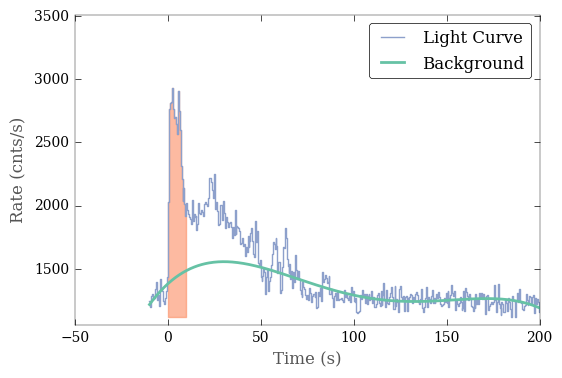

In [4]:
nai3.view_lightcurve(-10,200.,.5)

Oy! That is not so nice! Luckily, we can simply select another interval!

Auto-determined polynomial order: 1


Currently using 128 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian



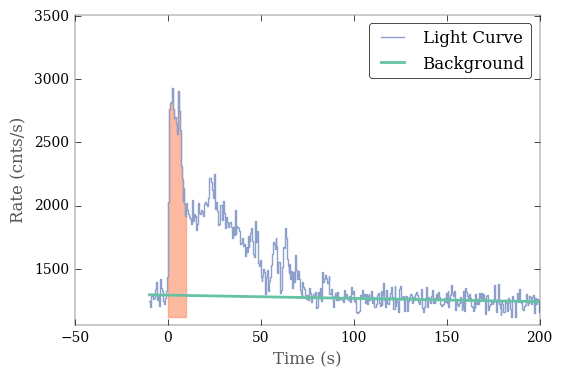

In [4]:
nai3.set_background_interval("-10.--1.","120-200") # You can select as many as required!
nai3.view_lightcurve(-10,200.,.5)

It is also possible to select multiple (disjoint only) src intervals

Currently using 128 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian



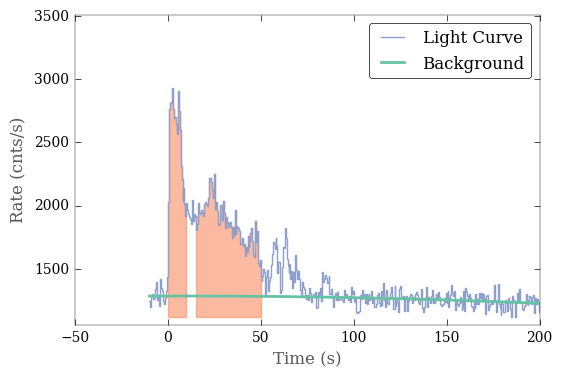

In [8]:
nai3.set_active_time_interval('0-10','15-50')

nai3.view_lightcurve(-10,200.,.5)

Selecting non-disjoint intervals will result in an error:

In [11]:
nai3.set_active_time_interval('0-10','5-50')

nai3.view_lightcurve(-10,200.,.5)

RuntimeError: Provided intervals are overlapping and hence invalid

In [9]:
# go back to our original selection
nai3.set_active_time_interval(src_selection)

Currently using 128 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian



Ok! This is a much better fit. If we change our source interval the counts are automatically recalculated.
### Energy selection

We need to select the energies we would like to fit over. GBM has over/underflow channels which must be exlcuded from the fit. This is not always at the same energy, so we need to check.
**FermiGBM_TTE_Like**  (and **FermiGBMLike** ) allow you to plot the count spectra so you can see what you will be excluding in the fit.

Range 10.0-30.0 translates to channels 6-21
Range 40.0-900.0 translates to channels 27-124
Now using 114 channels out of 128


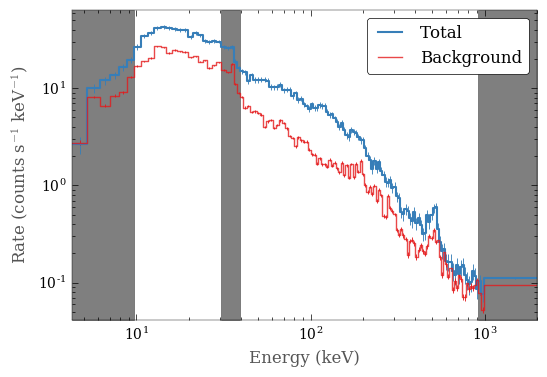

In [14]:
nai3.set_active_measurements("10.0-30.0", "40.0-900.0")
nai3.view_count_spectrum()

Range 250-43000 translates to channels 1-126
Now using 126 channels out of 128


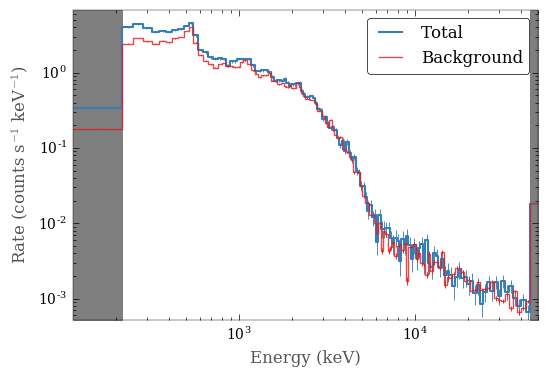

In [15]:
bgo0.set_active_measurements("250-43000")
bgo0.view_count_spectrum()

## Fitting!

We are now ready for the standard **3ML** process:


In [16]:
triggerName = 'bn080916009'
ra = 121.8
dec = -61.3


data_list = DataList(nai3,bgo0 )

band = Band()


GRB = PointSource( triggerName, ra, dec, spectral_shape=band )

model = Model( GRB )

model.display()

name,value,min_value,max_value,unit,delta,free
bn080916009.spectrum.main.Band.K,0.0001,None,None,1 / (cm2 keV s),1e-05,True
bn080916009.spectrum.main.Band.alpha,-1.0,-1.5,3.0,,0.1,True
bn080916009.spectrum.main.Band.xp,500.0,10.0,None,keV,50.0,True
bn080916009.spectrum.main.Band.beta,-2.0,-5.0,-1.6,,0.2,True


In [17]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,bn080916009.spectrum.main.Band.K,0.0284 +/- 0.0013,1 / (cm2 keV s)
1,bn080916009.spectrum.main.Band.alpha,-1.03 +/- 0.04,
2,bn080916009.spectrum.main.Band.xp,(1.08 +/- 0.23)e+03,keV
3,bn080916009.spectrum.main.Band.beta,-2.24 +/- 0.16,



NOTE: errors on parameters are approximate. Use get_errors().

(no nuisance parameters)

Correlation matrix:



1.00,0.90,-0.96,0.77
0.90,1.00,-0.93,0.73
-0.96,-0.93,1.00,-0.83
0.77,0.73,-0.83,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,1447.605176
NAI3,680.612269
BGO0,766.992907


We can examine our fit with the data:

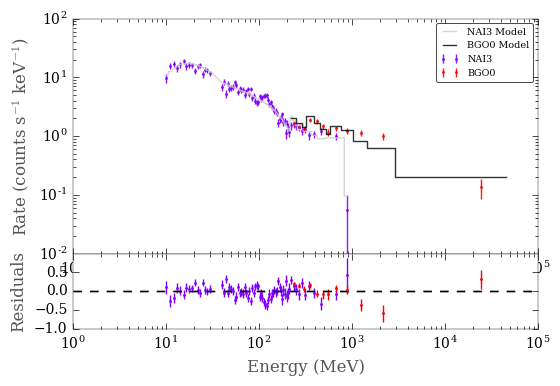

In [17]:
display_model_counts(nai3,bgo0,min_rate=1)

In [18]:
res = jl.get_errors()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,0.0284 -0.0009 +0.0011,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.030 -0.028 +0.033,
bn080916009.spectrum.main.Band.xp,(1.08 -0.17 +0.19)e+03,keV
bn080916009.spectrum.main.Band.beta,-2.24 -0.15 +0.12,



WARNING ReducingNumberOfSteps: Number of steps is not a multiple of the number of threads. Reducing steps to 16



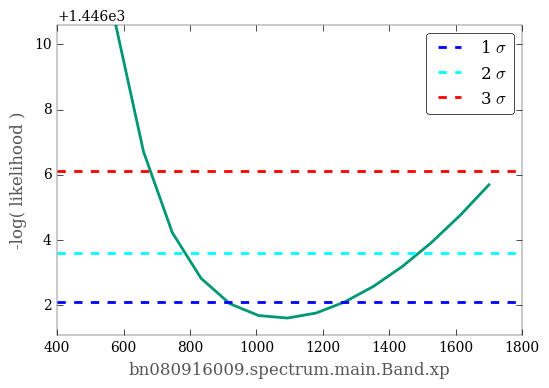

In [18]:
with parallel_computation():
    res = jl.get_contours(band.xp,400,1700,20)


WARNING ReducingNumberOfSteps: Number of steps is not a multiple of the number of threads. Reducing steps to 24



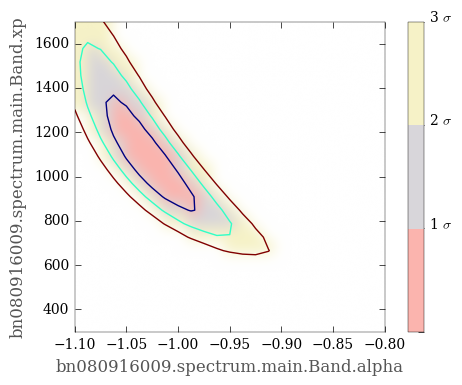

In [20]:
with parallel_computation():
    res = jl.get_contours(band.xp,300,1700,25,band.alpha,-1.1,-0.8,25)

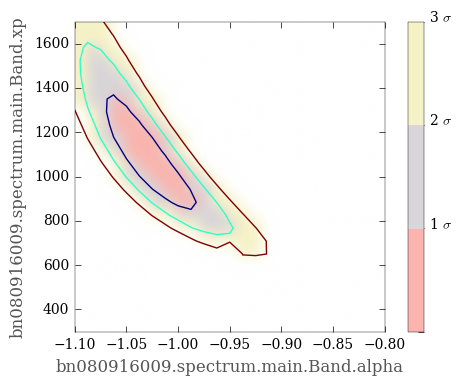

In [21]:
res = jl.get_contours(band.xp,300,1700,25,band.alpha,-1.1,-0.8,25)

## And if you really want to be sure => Go Bayesian!

In [21]:
# First define priors
# We can do it explicitly like this:
# (be careful not to choose the boundaries outside of the allowed value
# for the parameter, according to the min_value and max_value properties)

band.K.prior = Log_uniform_prior(lower_bound=1e-4, upper_bound=3)
band.xp.prior = Log_uniform_prior(lower_bound=10, upper_bound=1e5)

# or use the set_uninformative_prior method, which will use as lower_bound
# and upper_bound the current boundaries for the parameter. Such boundaries
# must exists and be finite

band.alpha.set_uninformative_prior(Uniform_prior)
band.beta.set_uninformative_prior(Uniform_prior)

bayes = BayesianAnalysis(model, data_list)

### Sample with Affine Invariant Sampling

In [20]:
samples = bayes.sample(n_walkers=50,burn_in=200, n_samples=1000)

Running burn-in of 200 samples...


Sampling...


Mean acceptance fraction: 0.55642


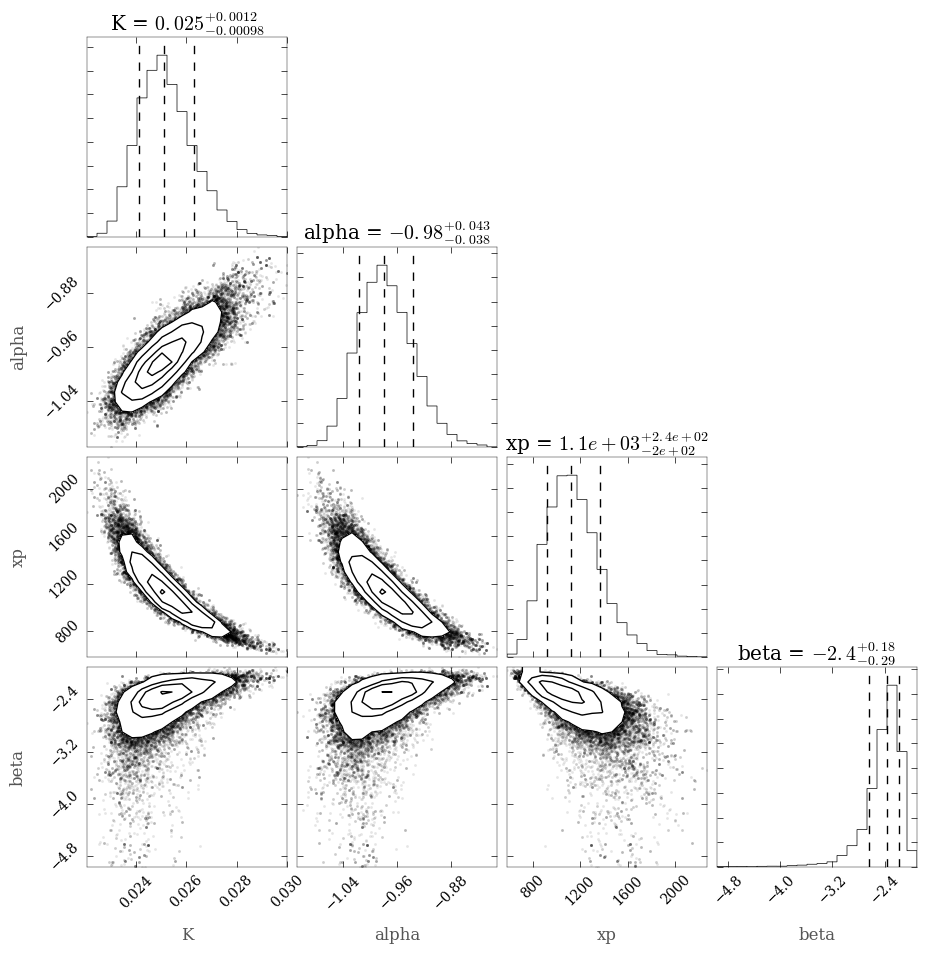

In [21]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)

### Sample with Nested Sampling (MULTINEST)

(see parallel demo for tips on parallel sampling with MPI)

In [22]:
samples = bayes.sample_multinest(n_live_points=400,resume=False)


Sampling...

MULTINEST has its own convergence criteria... you will have to wait blindly for it to finish
If INS is enabled, one can monitor the likelihood in the terminal for completion information
  analysing data from chains/fit-.txt


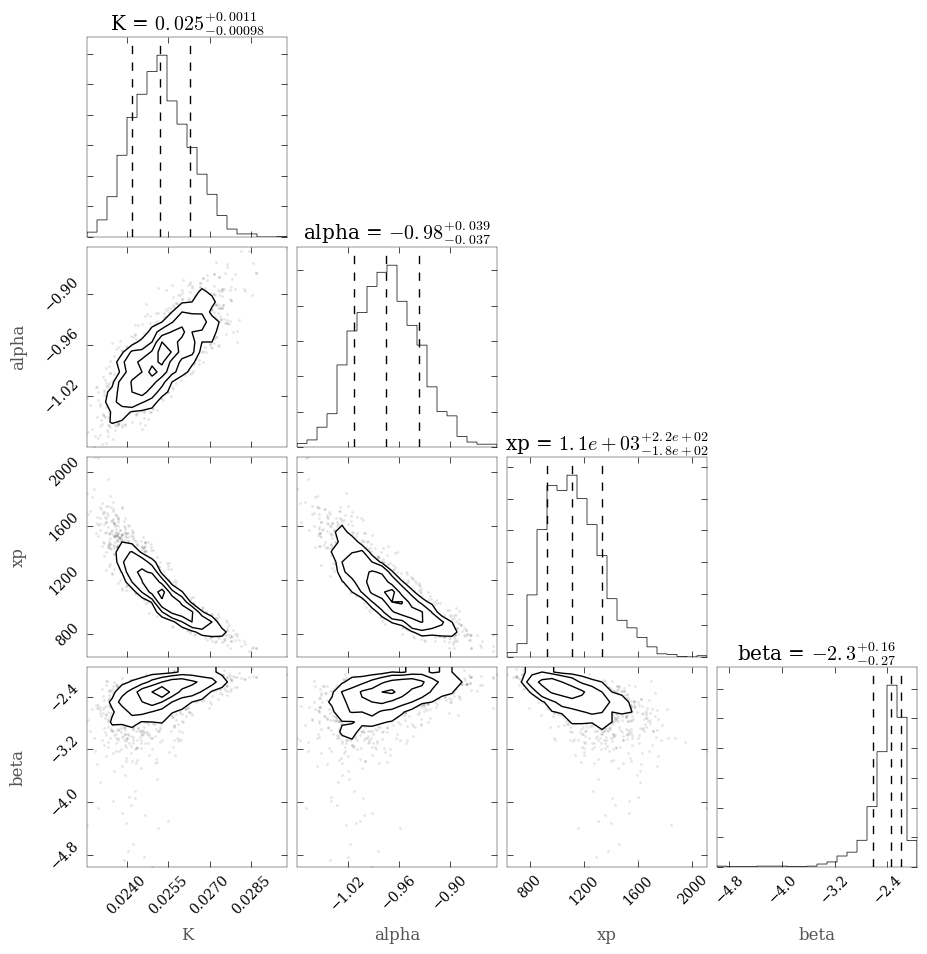

In [23]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)

#### Credible Regions

In [24]:
# equal-tailed credible regions
eq_tail = bayes.get_credible_intervals()


Name,Value,Unit
bn080916009.spectrum.main.Band.K,2.659 -0.031 +0.035,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.930 -0.012 +0.013,
bn080916009.spectrum.main.Band.xp,(8.6 -0.4 +0.4)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.13 -0.04 +0.032,



(probability 68)


In [25]:
# highest denisty intervals
hdi = bayes.get_highest_density_interval()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,2.66 -0.14 +0.14,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-0.93 -0.05 +0.05,
bn080916009.spectrum.main.Band.xp,(8.6 -1.5 +2.0)e+02,keV
bn080916009.spectrum.main.Band.beta,-2.13 -0.16 +0.12,


#### Effective free parameters (experimental)

Determine the complexity of your model and data 


In [26]:
bayes.get_effective_free_parameters()

3.9579152588503348

In [3]:
130 % 8

2

In [4]:
130 // 8

16

In [5]:
16 * 8

128

In [6]:
8 //130

0

In [9]:
130. /8.

16.25

In [14]:
130./2.

65.0

In [21]:
%pylab inline
def ceildiv(a, b):
    return -(-a // b)

Populating the interactive namespace from numpy and matplotlib


In [19]:
ceildiv(9,8)

2

In [37]:
cells = arange(9)

In [23]:
cells[::2]

array([0, 2, 4, 6, 8])

In [54]:
i=0



step = ceildiv(len(cells),8)
#cells[i*step : i*step +step]

In [51]:
step

3

In [46]:
cells

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [6]:
%pylab inline
nprocs = 8
cells = arange(128)

chunksize = int(math.ceil(len(cells) / float(nprocs)))
for i in range(nprocs):

    print cells[chunksize * i:chunksize * (i + 1)]

Populating the interactive namespace from numpy and matplotlib
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
[64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
[ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
[112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]



WARNING UserWarning: pylab import has clobbered these variables: ['f', 'gamma', 'mod']
`%matplotlib` prevents importing * from pylab and numpy



In [52]:
ceildiv(len(cells),8)

3

In [53]:
len(cells)//8

2

In [55]:
chunksize = int(math.ceil(len(cells) / float(nprocs)))

In [56]:
chunksize

3

In [3]:
from threeML.plugins.OGIP.eventlist import Polynomial, PolyUnbinnedLogLikelihood

In [14]:
p=Polynomial([1,1,1])
evt = nai3._evt_list._arrival_times

In [15]:
ll = PolyUnbinnedLogLikelihood(evt,p,evt.min(),evt.max(),evt.max()-evt.min())

In [16]:
ll([1,1,1])

-2567622.8034547493

In [17]:
ll.get_free_derivs()

array([  5.65329654e+03,  -4.06609597e+04,  -8.62426899e+06])

In [27]:
degree = 1
M = ll._model(ll._events)

-(ll._t_stop**(degree+1) - ll._t_start**(degree+1))/(degree+1) + (1/M *ll._events**degree).sum()

10661.226488017852